# **Fair K-means with automated threshold setting**

## **Overview:**

The project focuses on applying clustering techniques with fairness constraints to demographic data, specifically using clustering algorithms (e.g., k-means) to ensure fair representation of protected groups (e.g., race, gender) across clusters while maintaining clustering accuracy.

## **Key Objectives:**

Clustering with Fairness Constraints: Use clustering methods to group data, ensuring that each cluster reflects the desired distribution of protected attributes, such as race or gender.
Fairness Adjustment: Implement fairness adjustments to improve the balance of protected groups across clusters without significantly compromising clustering accuracy (e.g., silhouette scores).
Evaluate the Fairness-Accuracy Trade-off: Assess the impact of fairness adjustments on clustering quality, ensuring that the silhouette score does not drop beyond a threshold after adjustments.
Use of OpenAI API: Integrate AI-generated fairness strategies and recommended fairness distributions for different protected groups to guide the clustering process.
Methodology:

## **Data Preprocessing:**

Standardize features and prepare the dataset for clustering, ensuring fair representation across different protected groups.
Add demographic features such as Region and Age to the data for a comprehensive clustering analysis.
Fair K-means Clustering:
Perform k-means clustering while considering fairness, with clusters being adjusted iteratively to match a fairness distribution for the protected attribute.
Fairness adjustments are made by moving individuals between clusters, prioritizing groups that are overrepresented in certain clusters and underrepresented in others.

## **Fairness Adjustment Process:**

Adjust clusters to better reflect the expected distribution of protected groups while monitoring the silhouette score to ensure minimal disruption to clustering quality.
If the silhouette score drops significantly after an adjustment (more than a predefined threshold), further adjustments are halted to avoid sacrificing clustering accuracy.

## **Fairness Strategy and Thresholds:**
Use the OpenAI API to retrieve fairness strategies and predefined fairness distributions for the protected attribute.
The system dynamically adjusts cluster assignments based on these AI-recommended fairness distributions.
Evaluation:

## **Fairness Scores:**
Calculate and compare fairness scores across clusters before and after adjustments to assess improvements in demographic equity.

## **Silhouette Score:**
Track clustering quality by measuring silhouette scores before and after fairness adjustments.

## **Conclusion:**

**This project explores the balance between fairness and clustering accuracy, providing a method for adjusting cluster assignments to ensure more equitable representation of protected groups, which is crucial in applications such as hiring or demographic studies where fairness is a top priority. The approach uses advanced clustering techniques along with AI-driven fairness guidelines to achieve a balance that aligns with both ethical and practical objectives.**

## **Import necessary libraries**

In [4]:
import openai
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from collections import Counter
import json
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

### **API-key inputs**

In [6]:
# Set OpenAI API Key
openai.api_key = "***"

## **Setting Context to automate threshold settings for fairness scores**

In [8]:
def get_column_description(column_name, unique_values):
    """ Queries OpenAI API to interpret the meaning of the protected column. """
    prompt = f"""
    I have a dataset with a protected attribute named '{column_name}' that has the following unique values: {unique_values}.
    What's the distribution of {unique_values} in the global population. DO NOT DEFAULT TO EQUAL DISTRIBUTION AMONG ALL GROUPS!
    Provide a dictionary where keys are attribute values and values are their expected proportions (sum should be ~1). Be concise - not more than 2 lines
    """

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )

    return response['choices'][0]['message']['content']

## **Setting Fairness Thresholds**

**Input Parameters:**

column_name: The name of the protected attribute column (e.g., 'Race', 'Gender').
unique_values: The unique values (categories) within the protected attribute.

**Procedure:**

**1. Prompt Construction:**
The function constructs a prompt asking the OpenAI API to provide the distribution of the unique values of the protected attribute (column_name) in the global population, with proportions that sum to approximately 1.
The prompt emphasizes that the distribution should not default to equal allocation among the groups.

**2. API Query:**
The function queries the OpenAI ChatCompletion API (gpt-4 model) with the constructed prompt.

**3. Response Extraction:**
The function extracts the response from the API, which contains the fairness distribution in a dictionary-like string format.

**Dictionary Parsing:**
The function attempts to extract the dictionary-like string (between curly braces) from the response.
It uses eval to parse this string into an actual Python dictionary.

**Error Handling:**
If an error occurs during extraction or evaluation (e.g., invalid format), the function defaults to a uniform distribution where each unique value has equal proportion (1 / number of unique values).

**Output:**
The function returns a dictionary with the expected fairness distribution for each unique value of the protected attribute.


**Key Considerations:**
The function uses the OpenAI API to determine a fairness distribution based on global population proportions.
If the API response format is not as expected, the function defaults to an equal distribution.
The function assumes the response is a dictionary-like string that can be parsed directly.

In [10]:
def get_fairness_thresholds(column_name, unique_values):
    """
    Uses OpenAI API to get a predefined fairness distribution and converts it to a dictionary.
    The distribution will be directly extracted from the response between '{' and '}'.
    """
    prompt = f"""
    I have a dataset with a protected attribute named '{column_name}' that has the following unique values: {unique_values}.
    What's the latest expected distribution of {unique_values} in the total global population based on relevant and reliable sources. DO NOT DEFAULT TO EQUAL DISTRIBUTION AMONG ALL GROUPS!
    Provide a dictionary where keys are {unique_values} and values are their expected proportions (sum should be ~1). Be concise - not more than 2 lines
    """

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )

    response_content = response['choices'][0]['message']['content']

    print("Response Content: ", response_content)

    try:
        start = response_content.index('{')
        end = response_content.index('}') + 1  # Include closing brace
        dict_str = response_content[start:end]
        
        thresholds = eval(dict_str)  # Convert the dictionary string into an actual Python dictionary
    except Exception as e:
        print(f"Error in extracting or evaluating the dictionary: {e}")
        thresholds = {value: 1 / len(unique_values) for value in unique_values}  # Default to uniform distribution

    print(f'\nThresholds: {thresholds}\n')
    return thresholds


## **Providing user with context about chosen thresholds**

**Input Parameters:**
None (the function does not take any parameters).


**Procedure:**

**1. Prompt Construction:**
The function constructs a prompt asking the OpenAI API for an optimal fairness adjustment strategy in a clustering scenario, emphasizing that the best distribution should not default to equal allocation among all groups.

**2. API Query:**
The function queries the OpenAI ChatCompletion API (using the gpt-4 model) with the prompt, asking for a concise response (no more than two lines).
**3. Response Extraction:**
The function extracts the content of the response from the API and returns it.

**Output:**
The function returns the strategy for fairness adjustment suggested by the OpenAI API.

**Key Considerations:**
The function relies on the OpenAI API to provide a concise fairness strategy based on the input prompt.
The strategy focuses on avoiding equal allocation among groups and is expected to be tailored to the specific clustering scenario.

In [12]:
def get_fairness_strategy(): # Mainly to be used to provide context to end user - can be called later in fair_kmeans if required
    prompt = """
    Given a clustering scenario where demographic fairness is required, what is the best distribution? DO NOT DEFAULT TO EQUAL ALLOCATION AMONG ALL GROUPS!
    Be concise - not more than 2 lines
"""

    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[{"role": "user", "content": prompt}]
    )

    return response['choices'][0]['message']['content']

# **K-means algorithm**

In [14]:
def initialize_centroids(X, k, random_state=123):
    """ Randomly selects k data points as initial centroids. """
    np.random.seed(random_state)
    indices = np.random.choice(len(X), k, replace=False)
    return X[indices]
    
def assign_clusters(X, centroids):
    """ Assigns each data point to the nearest centroid. """
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(X, labels, k):
    """ Updates centroids as the mean of assigned data points. """
    return np.array([X[labels == i].mean(axis=0) for i in range(k)])


## **Creating a fairness score for the protected feature**

**Input Parameters:**
- df: DataFrame with the data and cluster assignments.
- protected_col: The column representing the protected attribute (e.g., race, gender).
- expected_distribution: The desired distribution of the protected attribute across clusters.

**Procedure:**

**Overall Population Distribution:**
- Count occurrences of each protected attribute value in the entire dataset.
- Calculate the overall proportion of each protected attribute value.

**Cluster-wise Distribution:**
- For each cluster, count occurrences of each protected attribute value.
- Calculate the proportion of each protected attribute value in the cluster.

**Fairness Calculation:**
- For each cluster, compute the absolute difference between the cluster’s distribution and the expected distribution for each protected attribute.
- Store these differences in a dictionary as fairness scores.

**Output:**
A dictionary (fairness_scores) where each cluster is a key and the value is another dictionary that shows the fairness score for each protected attribute within that cluster.


**Key Considerations:**
The function evaluates how closely each cluster's distribution of the protected attribute matches the expected distribution.
Lower fairness scores indicate better alignment with the desired distribution.

In [16]:
def compute_cluster_fairness(df, protected_col, expected_distribution):
    """ Computes fairness scores for each cluster. """
    fairness_scores = {}
    overall_count = dict(Counter(df[protected_col]))  
    overall_ratio = {k: v / sum(overall_count.values()) for k, v in overall_count.items()}

    for cluster in sorted(df['Cluster'].unique()):
        cluster_count = dict(Counter(df[df['Cluster'] == cluster][protected_col]))
        cluster_ratio = {k: cluster_count.get(k, 0) / sum(cluster_count.values()) for k in overall_ratio.keys()}

        fairness_scores[cluster] = {
            k: round(abs(cluster_ratio.get(k, 0) - expected_distribution[k]), 4)
            for k in expected_distribution
        }

    return fairness_scores

## **Using AI-defined strategy to fine-tune cluster fairness while minimizing distortion.**

**Input Parameters:**
- df: DataFrame with the data and cluster assignments.
- protected_col: The column representing the protected attribute (e.g., race, gender).
- expected_distribution: The desired distribution of the protected attribute across clusters.
- max_iterations: Maximum number of iterations to perform fairness adjustments (default is 100).
- silhouette_threshold: The maximum allowable drop in silhouette score before stopping adjustments (default is 0.05)
  
**Procedure:**

- Extract Feature Columns: Select all columns except the protected attribute and cluster assignments.
- Compute Initial Silhouette Score: Calculate the silhouette score of the dataset before any adjustments.

**Fairness Adjustment Loop:**
- Iterate up to max_iterations, computing fairness scores for each cluster.
- Sort clusters by their fairness scores.
- For each cluster, move an individual from an overrepresented group to an underrepresented group in another cluster.

**Recompute Silhouette Score:** After each adjustment, calculate the new silhouette score.

**Check for Silhouette Score Drop:** If the silhouette score drops too much (above silhouette_threshold), stop the adjustments.

**Output:**

The function returns the adjusted DataFrame with updated cluster assignments.

**Key Considerations:**

The function adjusts fairness across multiple clusters, not just the most and least fair clusters, by selecting overrepresented and underrepresented groups for movement.
It ensures that the silhouette score does not drop significantly, balancing clustering quality and fairness.
Fairness is iteratively adjusted while monitoring the impact on the silhouette score, ensuring that clustering remains of high quality while improving fairness across clusters.

In [18]:
from sklearn.metrics import silhouette_score

#Approach 1
'''
def advanced_fairness_adjustment(df, protected_col, expected_distribution, max_iterations=100, silhouette_threshold=0.05):
    """
    Adjust the clusters for fairness while ensuring silhouette score does not drop significantly.
    """
    
    # Extract the feature columns (excluding the protected attribute)
    feature_cols = [col for col in df.columns if col != protected_col and col != 'Cluster']
    X_scaled = df[feature_cols].values
    
    # Compute initial silhouette score before any fairness adjustments
    initial_silhouette = silhouette_score(X_scaled, df['Cluster'])
    print(f"Initial Silhouette Score: {initial_silhouette}")

    # Perform fairness adjustment for a maximum of max_iterations iterations
    for _ in range(max_iterations):
        fairness_scores = compute_cluster_fairness(df, protected_col, expected_distribution)

        # Find the most and least fair clusters
        worst_cluster = max(fairness_scores, key=lambda k: sum(fairness_scores[k].values()))
        best_cluster = min(fairness_scores, key=lambda k: sum(fairness_scores[k].values()))

        if worst_cluster == best_cluster:
            break  # No improvement possible

        overrepresented_group = max(fairness_scores[worst_cluster], key=fairness_scores[worst_cluster].get)
        underrepresented_group = min(fairness_scores[best_cluster], key=fairness_scores[best_cluster].get)

        # Candidate is an individual from the overrepresented group in the worst cluster
        candidate = df[(df['Cluster'] == worst_cluster) & (df[protected_col] == overrepresented_group)].sample(1)

        if not candidate.empty:
            # Move candidate from worst cluster to best cluster
            df.at[candidate.index[0], 'Cluster'] = best_cluster  

        # Recompute the silhouette score after the adjustment
        new_silhouette = silhouette_score(X_scaled, df['Cluster'])
        print(f"New Silhouette Score After Adjustment: {new_silhouette}")

        # Check if the silhouette score has dropped too much
        if initial_silhouette - new_silhouette > silhouette_threshold:
            print("Silhouette score dropped too much, stopping further adjustments.")
            break

    return df

'''

#Approach 2
def advanced_fairness_adjustment(df, protected_col, expected_distribution, max_iterations=100, silhouette_threshold=0.05):
    """
    Adjust the clusters for fairness while ensuring silhouette score does not drop significantly.
    This version adjusts fairness across multiple clusters, not just the most and least fair ones.
    """
    
    feature_cols = [col for col in df.columns if col != protected_col and col != 'Cluster']
    X_scaled = df[feature_cols].values
    
    initial_silhouette = silhouette_score(X_scaled, df['Cluster'])
    print(f"Initial Silhouette Score: {initial_silhouette}")

    for _ in range(max_iterations):
        fairness_scores = compute_cluster_fairness(df, protected_col, expected_distribution)

        sorted_clusters = sorted(fairness_scores.items(), key=lambda item: sum(item[1].values()), reverse=True)
        
        for cluster, scores in sorted_clusters:
            #overrepresented_group = max(scores, key=scores.get)
            #underrepresented_group = min(scores, key=scores.get)
            overrepresented_group = max(scores, key=lambda g: scores[g] - expected_distribution[g])
            underrepresented_group = min(scores, key=lambda g: expected_distribution[g] - scores[g])

            
            candidates = df[(df['Cluster'] == cluster) & (df[protected_col] == overrepresented_group)].sample(1)
            
            if not candidates.empty:
                target_cluster = next((c for c, s in sorted_clusters if underrepresented_group in s and c != cluster), None)
                #target_cluster = min(sorted_clusters, key=lambda c: expected_distribution[underrepresented_group] - fairness_scores[c[0]].get(underrepresented_group, 0))[0]
                if target_cluster:
                    df.at[candidates.index[0], 'Cluster'] = target_cluster

        new_silhouette = silhouette_score(X_scaled, df['Cluster'])
        print(f"New Silhouette Score After Adjustment: {new_silhouette}")

        if initial_silhouette - new_silhouette > silhouette_threshold:
            print("Silhouette score dropped too much, stopping further adjustments.")
            break

    return df


## **Adjusting the K-means clusters to combine the underlying k-means algorithm with fairness strategy and LLM-prompt layer**

This method implements a custom k-means clustering algorithm with fairness constraints. It performs k-means clustering while ensuring that the distribution of the protected attribute (e.g., race, gender) across clusters meets fairness criteria, without significantly compromising the clustering quality (measured by the silhouette score).

**Key Steps:**

**1. Input Parameters:**
- data: The input DataFrame containing features and the protected attribute.
- n_clusters: The number of clusters for k-means.
- protected_col: The column representing the protected attribute (e.g., race, gender).
- max_iterations: Maximum iterations for the fairness adjustment process.
- random_state: A seed for random initialization of centroids.

**2. Feature Extraction and Scaling:**
- Extracts feature columns from the data (excluding the protected attribute and cluster assignment).
- Scales the features using StandardScaler for better performance in clustering.

**3. AI-Recommended Fairness Distribution:**
- Queries an external AI API (presumably OpenAI) to get the recommended fairness distribution for the protected attribute across clusters.
- The expected distribution is printed for reference.

**4. K-Means Clustering:**
- Initializes centroids randomly.
- Performs k-means clustering (up to 100 iterations) to assign data points to clusters based on the feature values.

**5.Silhouette Score (Pre-adjustment):**
- Computes the silhouette score, a measure of how well the data points fit into their clusters, before any fairness adjustments.

**6. Fairness Adjustment:**
- Computes fairness before adjustments using the expected distribution.
- Calls advanced_fairness_adjustment to adjust the clusters based on the fairness distribution, ensuring that the silhouette score does not drop too much (by setting a threshold, e.g., 0.03).

**7. Fairness After Adjustment:**
- Computes fairness again after the adjustment to check the impact of the fairness adjustments on the cluster composition.
- Silhouette Score (Post-adjustment):
- Computes the silhouette score again after fairness adjustments to evaluate if the quality of clustering has been maintained.

**Output:**
Returns the adjusted DataFrame (data) and a dictionary containing:
Fairness before and after adjustments.
Initial and post-adjustment silhouette scores.

**Purpose:**
The method ensures that clustering not only performs well in terms of group cohesion (silhouette score) but also respects fairness constraints related to the protected attribute, making the clustering process both fair and effective.

In [20]:
from sklearn.metrics import silhouette_score

def fair_kmeans(data, n_clusters, protected_col, max_iterations=100, random_state=123):
    """
    Custom k-means clustering with AI-defined fairness constraints and an AI-suggested fairness strategy.
    """
    
    feature_cols = [col for col in data.columns if col != protected_col and col != 'Cluster']
    X = data[feature_cols].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    unique_values = data[protected_col].unique().tolist()

    print(f"Querying OpenAI API for fairness distribution of {unique_values}...")
    expected_distribution = get_fairness_thresholds(protected_col, unique_values)  # Assuming this function returns a dict of expected proportions
    print(f"AI-Recommended Fairness Distribution: {expected_distribution}")

    
    centroids = initialize_centroids(X_scaled, n_clusters, random_state)
    
    for _ in range(100):  
        labels = assign_clusters(X_scaled, centroids)
        new_centroids = update_centroids(X_scaled, labels, n_clusters)

        if np.all(centroids == new_centroids):
            break  # Stop if centroids don't change

        centroids = new_centroids

    data['Cluster'] = labels  # Assign final clusters

    initial_silhouette = silhouette_score(X_scaled, labels)
    print(f"Initial Silhouette Score: {initial_silhouette}")
    
    fairness_before = compute_cluster_fairness(data, protected_col, expected_distribution)

    data = advanced_fairness_adjustment(data, protected_col, expected_distribution, max_iterations, silhouette_threshold=0.05)

    fairness_after = compute_cluster_fairness(data, protected_col, expected_distribution)
    
    new_silhouette = silhouette_score(X_scaled, data['Cluster'])
    print(f"Silhouette Score After Adjustment: {new_silhouette}")

    return data, {'before': fairness_before, 'after': fairness_after, 'initial_silhouette': initial_silhouette, 'new_silhouette': new_silhouette}


## **Testing, evaluating and comparing model fairness performance of the conventional K-means approach vs. our FairKMeans approach using a synthetic dataset** 

## **Dataset generation and Conventional K-Means**

In [23]:
np.random.seed(42)
n_samples = 3000
n_features = 2
n_clusters = 4

# Generate random feature data
X = np.random.rand(n_samples, n_features)

protected_attribute = np.random.choice(["White", "Black","Asian","Hispanic"], size=n_samples)

# Create DataFrame
df = pd.DataFrame(X, columns=['Feature1', 'Feature2'])
df['Race'] = protected_attribute

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Feature1', 'Feature2']])

# Perform KMeans clustering
kmeans = KMeans(n_clusters=n_clusters)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Print the first few rows with the cluster assignments
print(df.head())

# Calculate Race Distribution in each cluster
race_distribution = {}
for cluster in df['Cluster'].unique():
    cluster_data = df[df['Cluster'] == cluster]
    race_count = dict(Counter(cluster_data['Race']))
    race_distribution[cluster] = {k: v / len(cluster_data) for k, v in race_count.items()}


# Display the race distribution per cluster
for cluster, distribution in race_distribution.items():
    print(f"Cluster {cluster} Race Distribution: {distribution}")

   Feature1  Feature2   Race  Cluster
0  0.374540  0.950714  White        1
1  0.731994  0.598658  White        3
2  0.156019  0.155995  Asian        0
3  0.058084  0.866176  White        1
4  0.601115  0.708073  White        3
Cluster 1 Race Distribution: {'White': 0.2583222370173103, 'Asian': 0.2237017310252996, 'Hispanic': 0.24234354194407456, 'Black': 0.2756324900133156}
Cluster 3 Race Distribution: {'White': 0.2727272727272727, 'Asian': 0.2571428571428571, 'Hispanic': 0.24025974025974026, 'Black': 0.22987012987012986}
Cluster 0 Race Distribution: {'Asian': 0.26162018592297476, 'Hispanic': 0.2337317397078353, 'White': 0.2549800796812749, 'Black': 0.249667994687915}
Cluster 2 Race Distribution: {'Hispanic': 0.2603305785123967, 'Asian': 0.24517906336088155, 'White': 0.24242424242424243, 'Black': 0.25206611570247933}


## **Fair KMeans with distribution of the protected feature**

In [25]:
df_fair, fairness_scores = fair_kmeans(df, n_clusters=4, protected_col='Race')

# Display the DataFrame with cluster assignments
print(df_fair.head())

# Display fairness scores before and after adjustments
print(fairness_scores)

Querying OpenAI API for fairness distribution of ['White', 'Asian', 'Hispanic', 'Black']...
Response Content:  From the latest world population review data, the distribution would be `{'White': 0.16, 'Asian': 0.6, 'Hispanic': 0.0835, 'Black': 0.15}`

Thresholds: {'White': 0.16, 'Asian': 0.6, 'Hispanic': 0.0835, 'Black': 0.15}

AI-Recommended Fairness Distribution: {'White': 0.16, 'Asian': 0.6, 'Hispanic': 0.0835, 'Black': 0.15}
Initial Silhouette Score: 0.41110452288657384
Initial Silhouette Score: 0.41110823531973334
New Silhouette Score After Adjustment: 0.4090749419646095
New Silhouette Score After Adjustment: 0.4077750718608185
New Silhouette Score After Adjustment: 0.4064491215659715
New Silhouette Score After Adjustment: 0.4052094472627851
New Silhouette Score After Adjustment: 0.4035582298404495
New Silhouette Score After Adjustment: 0.4017969904276251
New Silhouette Score After Adjustment: 0.40053697225277046
New Silhouette Score After Adjustment: 0.39895139787411565
New Silhou

## **Fairness Scores Evaluation by Cluster - We can observe that the fairness cluster 1,2&3 reduced  in order to make cluster 2 fairer - Cluster 0 became more unfair as a result.**

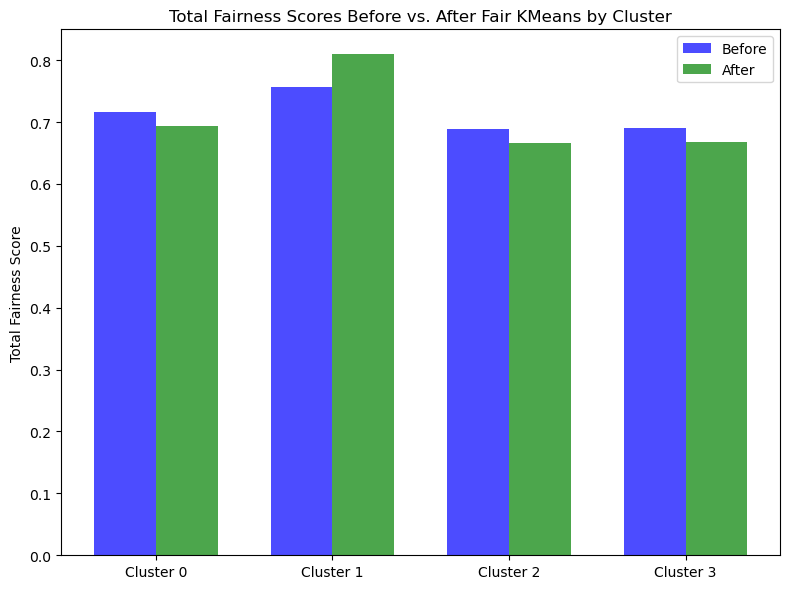

In [27]:
before_cluster_sum = {cluster: sum(fairness_scores['before'][cluster].values()) for cluster in fairness_scores['before']}
after_cluster_sum = {cluster: sum(fairness_scores['after'][cluster].values()) for cluster in fairness_scores['after']}


clusters = list(before_cluster_sum.keys())  # Cluster numbers (0, 1, 2)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the total fairness scores before and after for each cluster
bar_width = 0.35
x = range(len(clusters))

ax.bar(x, before_cluster_sum.values(), bar_width, label='Before', alpha=0.7, color='b', align='center')
ax.bar([p + bar_width for p in x], after_cluster_sum.values(), bar_width, label='After', alpha=0.7, color='g', align='center')

# Customize the plot
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels([f"Cluster {i}" for i in clusters])
ax.set_ylabel("Total Fairness Score")
ax.set_title("Total Fairness Scores Before vs. After Fair KMeans by Cluster")
ax.legend()

plt.tight_layout()
plt.show()

## **Model performance - KMeans vs. FairKMeans:**

## As expected, we see a marginal compromise in grouping in order to ensure ideal representation of clusters

Regular KMeans Silhouette Score: 0.4111021356966334
Fair KMeans Silhouette Score: 0.3604619621550847


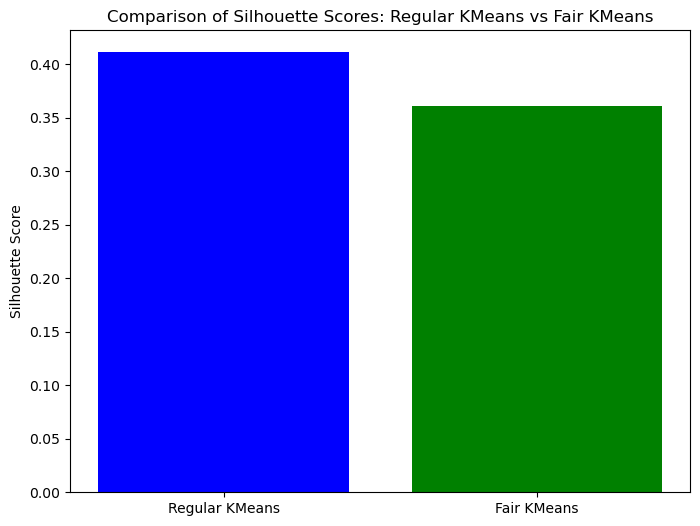

In [29]:
regular_kmeans_labels = kmeans.labels_
fair_kmeans_labels = df_fair['Cluster']
regular_silhouette_score = silhouette_score(X, regular_kmeans_labels)
fair_silhouette_score = silhouette_score(X, fair_kmeans_labels)

# Print silhouette scores for comparison
print(f"Regular KMeans Silhouette Score: {regular_silhouette_score}")
print(f"Fair KMeans Silhouette Score: {fair_silhouette_score}")

# Plot the comparison
methods = ['Regular KMeans', 'Fair KMeans']
silhouette_scores = [regular_silhouette_score, fair_silhouette_score]

plt.figure(figsize=(8, 6))
plt.bar(methods, silhouette_scores, color=['blue', 'green'])
plt.ylabel('Silhouette Score')
plt.title('Comparison of Silhouette Scores: Regular KMeans vs Fair KMeans')
plt.show()

## **Fair KMeans to group individuals based on income while ensuring fairness between urban and rural areas.**

In [31]:
np.random.seed(123)

# Parameters
n_samples = 1000
regions = ['Urban', 'Rural']
region_prob = [0.7, 0.3]  # 70% Urban, 30% Rural

# Generate data
income = np.random.normal(loc=50000, scale=15000, size=n_samples)  # Normally distributed income
region = np.random.choice(regions, size=n_samples, p=region_prob)  # Region distribution

# Generate random age data between 18 and 80
age = np.random.randint(18, 81, size=n_samples)

# Create the DataFrame
df_income = pd.DataFrame({
    'Income': income,
    'Region': region,
    'Age': age
})

# Normalize the income data to make clustering more effective
scaler = StandardScaler()
df_income[['Income','Age']] = scaler.fit_transform(df_income[['Income','Age']])

# Show the first few rows
df_income.head()

,Income,Region,Age
0,-1.045243,Rural,-1.410446
1,1.036094,Urban,-0.917704
2,0.322289,Urban,0.943765
3,-1.465576,Urban,-0.370213
4,-0.538612,Rural,0.232027


In [32]:
kmeans_v2 = KMeans(n_clusters=4, random_state=123)
df_income['Cluster_Normal'] = kmeans_v2.fit_predict(df_income[['Income','Age']])

# Check the distribution of Urban/Rural across clusters
cluster_distribution_normal = df_income.groupby(['Cluster_Normal', 'Region']).size().unstack(fill_value=0)
print("Cluster distribution without fairness constraints:")
print(cluster_distribution_normal)

Cluster distribution without fairness constraints:
Region          Rural  Urban
Cluster_Normal              
0                  90    175
1                  77    206
2                  56    146
3                  96    154


In [33]:
df_fair_v2, fairness_scores_v2 = fair_kmeans(df_income, n_clusters=4, protected_col='Region')
# Check the distribution of Urban/Rural across clusters for Fair KMeans
cluster_distribution_fair_v2 = df_fair_v2.groupby(['Cluster', 'Region']).size().unstack(fill_value=0)
print("Cluster distribution with fairness constraints:")
print(cluster_distribution_fair_v2)

Querying OpenAI API for fairness distribution of ['Rural', 'Urban']...
Response Content:  According to the United Nations' World Urbanization Prospects 2018, approximately 55% of the world's population lives in urban areas, while 45% live in rural areas. These proportions can be represented as follows:
{'Urban': 0.55, 'Rural': 0.45}

Thresholds: {'Urban': 0.55, 'Rural': 0.45}

AI-Recommended Fairness Distribution: {'Urban': 0.55, 'Rural': 0.45}
Initial Silhouette Score: 0.5472158265245771
Initial Silhouette Score: 0.5641861951915526
New Silhouette Score After Adjustment: 0.5565523192139824
New Silhouette Score After Adjustment: 0.5486914413865419
New Silhouette Score After Adjustment: 0.5408185275737919
New Silhouette Score After Adjustment: 0.5340296467734854
New Silhouette Score After Adjustment: 0.5318072783081113
New Silhouette Score After Adjustment: 0.5262371480184904
New Silhouette Score After Adjustment: 0.5228349704097696
New Silhouette Score After Adjustment: 0.51675925132658

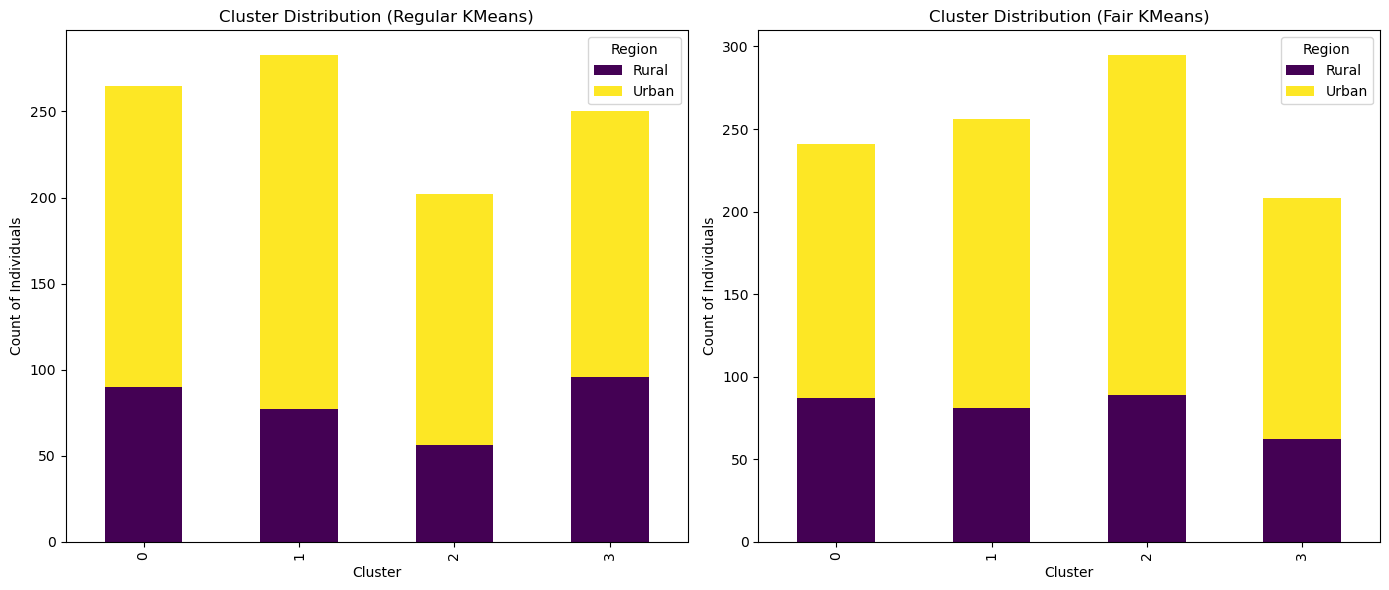

In [34]:
# Compare Cluster Distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for regular KMeans
cluster_distribution_normal.plot(kind='bar', stacked=True, ax=ax[0], colormap="viridis")
ax[0].set_title('Cluster Distribution (Regular KMeans)')
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Count of Individuals')
ax[0].legend(title='Region')

# Plot for Fair KMeans
cluster_distribution_fair_v2.plot(kind='bar', stacked=True, ax=ax[1], colormap="viridis")
ax[1].set_title('Cluster Distribution (Fair KMeans)')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Count of Individuals')
ax[1].legend(title='Region')

plt.tight_layout()
plt.show()

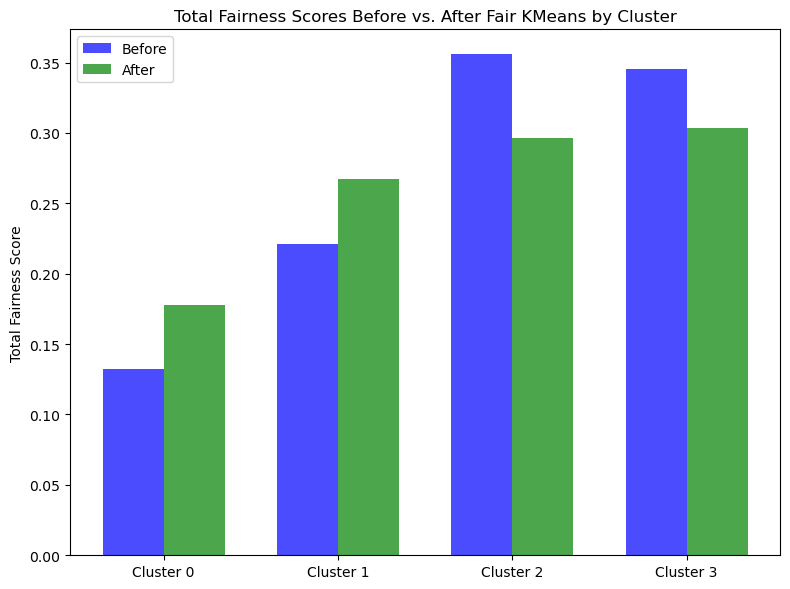

In [35]:
before_cluster_sum = {cluster: sum(fairness_scores_v2['before'][cluster].values()) for cluster in fairness_scores_v2['before']}
after_cluster_sum = {cluster: sum(fairness_scores_v2['after'][cluster].values()) for cluster in fairness_scores_v2['after']}


clusters = list(before_cluster_sum.keys())  # Cluster numbers (0, 1, 2)

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the total fairness scores before and after for each cluster
bar_width = 0.35
x = range(len(clusters))

ax.bar(x, before_cluster_sum.values(), bar_width, label='Before', alpha=0.7, color='b', align='center')
ax.bar([p + bar_width for p in x], after_cluster_sum.values(), bar_width, label='After', alpha=0.7, color='g', align='center')

# Customize the plot
ax.set_xticks([p + bar_width / 2 for p in x])
ax.set_xticklabels([f"Cluster {i}" for i in clusters])
ax.set_ylabel("Total Fairness Score")
ax.set_title("Total Fairness Scores Before vs. After Fair KMeans by Cluster")
ax.legend()

plt.tight_layout()
plt.show()

## **Clearly, fairness score decreased for clusters with severe imbalance in the "Region" class but this takes a hit on the quality of clustering.**

## This takes us to the Fairness-Accuracy trade-off similar to the Bias-Variance trade-off. 

### The fairness-accuracy trade-off in clustering involves balancing the goal of creating well-separated, cohesive clusters (high clustering accuracy) with ensuring fair representation of protected groups across clusters.

- Without fairness constraints, clusters may naturally over- or under-represent certain groups, achieving high accuracy but potentially creating unfair outcomes.
- With fairness constraints, adjustments are made to balance group representation, which may reduce clustering accuracy (e.g., lower silhouette scores) as members are moved between clusters to meet fairness goals.

### The trade-off is managed by setting thresholds for silhouette score or incorporating fairness penalties. In applications where fairness is critical (e.g., hiring), it may be prioritized over clustering accuracy. Conversely, in other cases, a balance is sought based on specific application needs.

### Ultimately, the challenge is to find an optimal balance where both fairness and clustering quality meet the desired standards.